In [298]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import plot_roc_curve

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF, PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, precision_score, 
                                    recall_score, accuracy_score, r2_score, 
                                    plot_confusion_matrix)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, plot_confusion_matrix
from sklearn.cluster import DBSCAN

from sklearn import (
    cluster, decomposition, ensemble, manifold, 
    random_projection, preprocessing)
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# from sklearn.neighbors import KNeighborsRegressor

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random

import json



In [299]:
df = pd.read_json('../../data/basic_dataset.json')

In [300]:
df.head()

,tweet_id,tweet_date,tweet_text,is_reply,is_quote,is_retweet,sensitive,hashtags,mentions,u_verified,u_egg,u_followers,u_created,retweets,favorites
0,1311093385688735744,Tue Sep 29 23:59:56 +0000 2020,Biden a professional debater?? Hardly!! More ...,0,1,0,0,[],[],0,0,4065,Sat Feb 27 00:36:23 +0000 2010,0,0
1,1311093394400333824,Tue Sep 29 23:59:58 +0000 2020,RT @DarDar458: #PresidentialDebate #Debates202...,0,1,1,0,"[{'text': 'PresidentialDebate', 'indices': [15...","[{'screen_name': 'DarDar458', 'name': 'DarDar4...",0,0,31031,Fri Apr 10 02:47:29 +0000 2009,1,0
2,1311093401652277252,Wed Sep 30 00:00:00 +0000 2020,How can Biden stand a chance against Trump in ...,0,0,0,0,"[{'text': 'VarneyCo', 'indices': [259, 268]}, ...","[{'screen_name': 'wjmcgurn', 'name': 'Bill McG...",1,0,663539,Wed Apr 13 16:27:54 +0000 2011,25,100
3,1311093410737070086,Wed Sep 30 00:00:02 +0000 2020,RT @abbydphillip: Very reminiscent of pre-2018...,0,1,1,0,[],"[{'screen_name': 'abbydphillip', 'name': 'Abby...",1,0,21737,Sat Nov 07 16:57:16 +0000 2009,351,0
4,1311093419100561408,Wed Sep 30 00:00:04 +0000 2020,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,0,0,1,0,[],"[{'screen_name': 'RudyGiuliani', 'name': 'Rudy...",0,0,893,Wed Jun 03 04:44:06 +0000 2009,15672,0


In [301]:
def lemmatizer(string):
    # Lemmatize a string and return it in its original format
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w)
                    for w in w_tokenizer.tokenize(string)
                    if "http" not in w])

df['lower_text'] = df['tweet_text'].apply(lambda x: str(x).lower())
df['lemmatized'] = df['tweet_text'].apply(lambda x: lemmatizer(x))

In [302]:
tweets = df.lemmatized.values

In [303]:
stop_words = list(STOPWORDS)
stop_words.append('rt')

In [304]:
def orig_vect(X_train, custom_stopwords):
    '''
    pass in x training data to fit and transform to

    Returns:
     vectorizer, x_train vectorized
    '''
    vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features = 100, analyzer='word', ngram_range=(1,2))
    x_train_vect = vectorizer.fit_transform(X_train)
    return vectorizer, x_train_vect

In [305]:
vectorizer, x_train_vect = orig_vect(tweets, stop_words)

/home/heather/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [306]:
x_train_vect

<140337x100 sparse matrix of type '<class 'numpy.int64'>'
	with 504418 stored elements in Compressed Sparse Row format>

In [307]:
features = vectorizer.get_feature_names()
vect_features = x_train_vect.toarray().mean(axis = 0)

In [308]:
top_words = np.array(features)[vect_features.argsort()[::-1][:100]]

Text(0.5, 1.0, 'Top Terms')

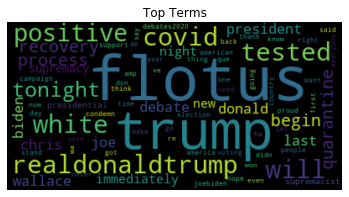

In [309]:
fig, ax = plt.subplots()

wordcloud = WordCloud().generate(' '.join(top_words))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title('Top Terms')
# plt.savefig('Debate_wordcloud.png');

In [310]:
for i in df.columns:
    print(i)

tweet_id
tweet_date
tweet_text
is_reply
is_quote
is_retweet
sensitive
hashtags
mentions
u_verified
u_egg
u_followers
u_created
retweets
favorites
lower_text
lemmatized


In [314]:
y = df['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(x_train_vect.todense(), y, random_state = 1, test_size = 0.25)

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [315]:
model = RandomForestRegressor(n_jobs=-1, max_depth=3)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_jobs=-1)

In [316]:
y_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8370401534889643, 0.8394251183915491)

Find top screen names and Hashtags that are mentioned and one hot and code those

HEATHER

That will tell us if using the hashtags gets more engagement on Twitter

 'entities.user_mentions', 'entities.hashtags'

In [17]:
for i in df.columns:
    print(i)

created_at
id
id_str
full_text
truncated
display_text_range
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
quoted_status_id
quoted_status_id_str
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_https
user

In [246]:
# screen_names = {}
# for i in range(len(lst)):
#     sn = lst[i]['screen_name']
#     if sn not in screen_names:
#         screen_names[sn] = 1
#     else:
#         screen_names[sn] += 1
# print(screen_names)

In [388]:
# import ast
# # >>> ast.literal_eval("{'muffin' : 'lolz', 'foo' : 'kitty'}")
# # {'muffin': 'lolz', 'foo': 'kitty'}
# # ast.literal_eval(df['entities.user_mentions'].values[1:][0][1:-1])

# s = df['entities.user_mentions'].values[1:][0][1:-1]
# json_acceptable_string = s.replace("'", "\"")

# d = json.loads(json_acceptable_string)

In [395]:
screen_names = {}
for text in df.tweet_text:
    if text[:3] == 'RT ':
        pass
    elif '@' in text:
        lst = text.split()
        ats = [at for at in lst if at[0] == '@']
        for names in ats:
            names = names.replace(':', '')
            if names not in screen_names:
                screen_names[names] = 1
            else:
                screen_names[names] += 1
    else:
        pass

In [396]:
screen_names

{'@wjmcgurn': 2,
 '@laggerific': 1,
 '@jondoc900': 1,
 '@JoeBiden': 2964,
 '@rodala2904': 1,
 '@eleazar_arocha': 1,
 '@GOPChairwoman': 85,
 '@charliekirk11': 57,
 '@PandaGetsHangry': 1,
 '@Maximus_4EVR': 1,
 '@realDonaldTrump': 9133,
 '@skb_sara': 1,
 '@AJLovesUSA': 1,
 '@KatTheHammer1': 1,
 '@MAGA_Engineer': 1,
 '@JillRTeamXRP': 1,
 '@trumpwoman2020': 1,
 '@Pickles0201': 1,
 '@US_Threepers': 1,
 '@KamalaHarris': 364,
 '@mark_w21': 1,
 '@Real_popehentai': 1,
 '@MatthewJshow': 40,
 '@MSignorile': 1,
 '@FoxNews': 206,
 '@TrumpWarRoom': 265,
 '@CrystalR95123': 1,
 '@TheDemCoalition': 21,
 '@WilliamClarke59': 1,
 '@tedcruz': 88,
 '@SenTedCruz': 53,
 '@lauti_grassi': 1,
 '@hotsaucedads': 1,
 '@DMyers25': 1,
 '@adamcarolla': 1,
 '@Ron_Christie': 3,
 '@Weinsteinlaw': 12,
 '@rayne67501': 1,
 '@casey81718900': 1,
 '@Strandjunker': 1,
 '@MarshaBlackburn': 28,
 '@nypost': 8,
 '@SenKamalaHarris': 45,
 '@ChrisStigall': 2,
 '@mmpadellan': 46,
 '@DonaldJTrumpJr': 158,
 '@EvanAKilgore': 17,
 '@DanRath

In [397]:
names = np.array(list(screen_names.keys()))
count = np.array(list(screen_names.values()))

In [398]:
top_25_names = names[count.argsort()[::-1]][:26]
top_25_count = count[count.argsort()[::-1]][:26]

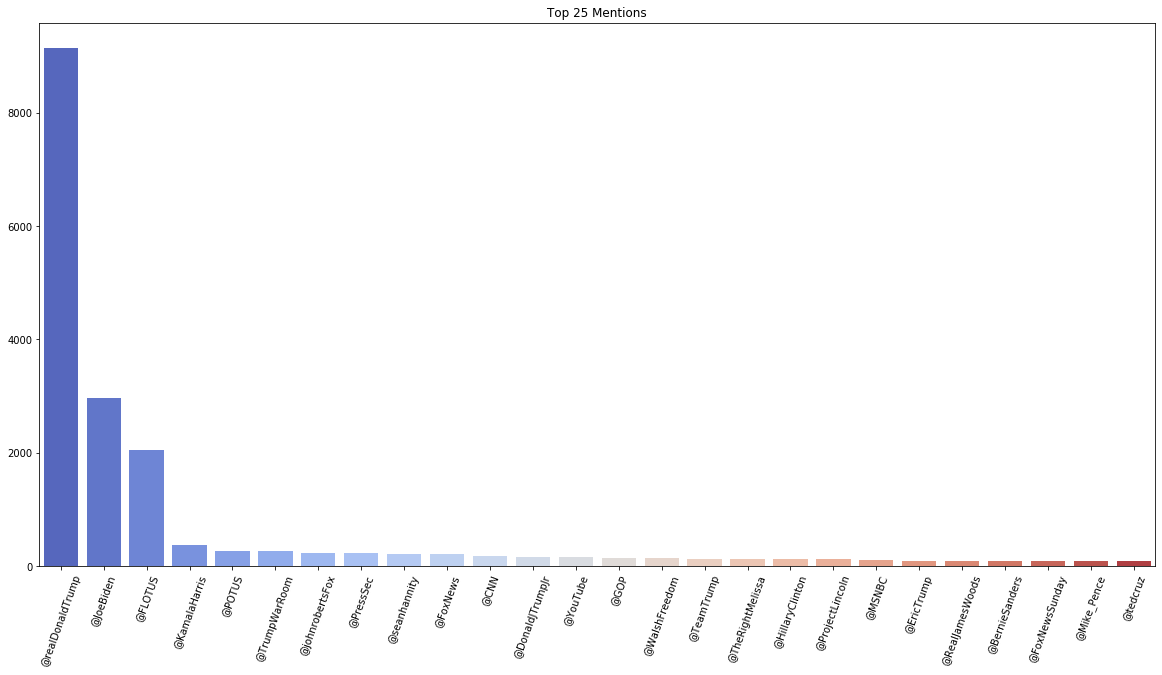

In [399]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(top_25_names, top_25_count, palette='coolwarm')
plt.xticks(rotation=70)
plt.title('Top 25 Mentions');

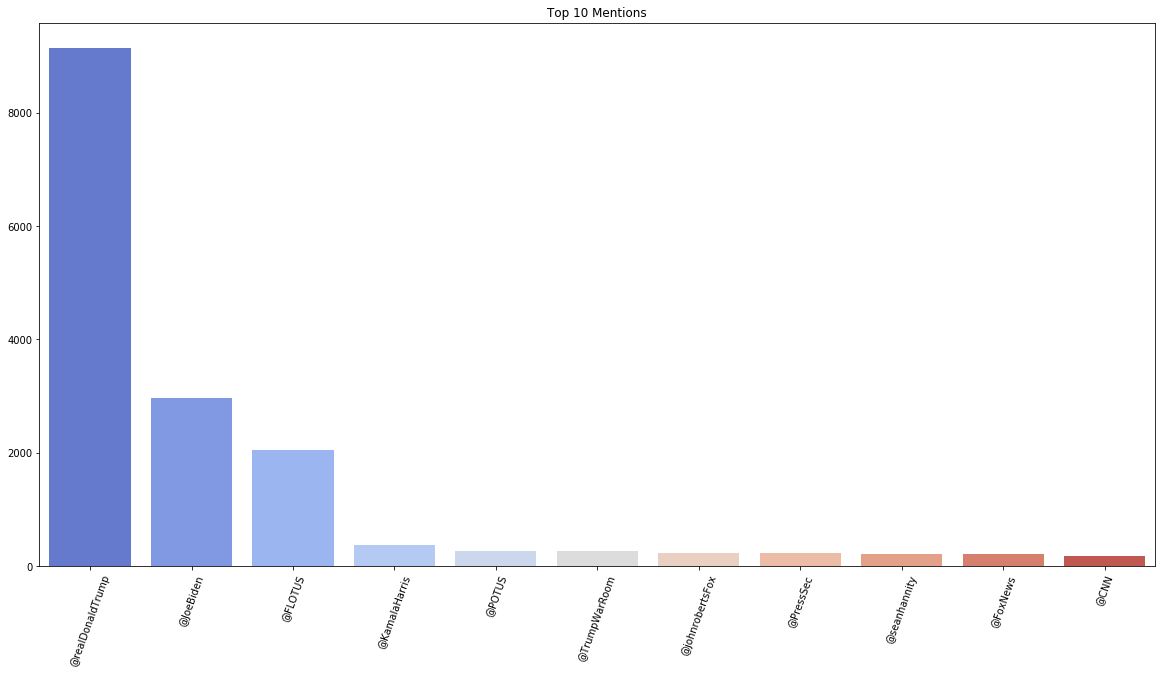

In [400]:
top_10_names = names[count.argsort()[::-1]][:11]
top_10_count = count[count.argsort()[::-1]][:11]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(top_10_names, top_10_count, palette='coolwarm')
plt.xticks(rotation=70)
plt.title('Top 10 Mentions');

One hot and Code the top 10 mentions 

In [401]:
top_10_names

array(['@realDonaldTrump', '@JoeBiden', '@FLOTUS', '@KamalaHarris',
       '@POTUS', '@TrumpWarRoom', '@johnrobertsFox', '@PressSec',
       '@seanhannity', '@FoxNews', '@CNN'], dtype='<U127')

In [404]:
non_rt_df = df[df['is_retweet'] == 0]

In [407]:
# df.head()

In [405]:
non_rt_df

,tweet_id,tweet_date,tweet_text,is_reply,is_quote,is_retweet,sensitive,hashtags,mentions,u_verified,u_egg,u_followers,u_created,retweets,favorites,lower_text,lemmatized
0,1311093385688735744,Tue Sep 29 23:59:56 +0000 2020,Biden a professional debater?? Hardly!! More ...,0,1,0,0,[],[],0,0,4065,Sat Feb 27 00:36:23 +0000 2010,0,0,biden a professional debater?? hardly!! more ...,Biden a professional debater?? Hardly!! More l...
2,1311093401652277252,Wed Sep 30 00:00:00 +0000 2020,How can Biden stand a chance against Trump in ...,0,0,0,0,"[{'text': 'VarneyCo', 'indices': [259, 268]}, ...","[{'screen_name': 'wjmcgurn', 'name': 'Bill McG...",1,0,663539,Wed Apr 13 16:27:54 +0000 2011,25,100,how can biden stand a chance against trump in ...,How can Biden stand a chance against Trump in ...
11,1311093473819242496,Wed Sep 30 00:00:17 +0000 2020,@laggerific @jondoc900 @JoeBiden You may get b...,1,0,0,0,"[{'text': 'Trump2020', 'indices': [105, 115]},...","[{'screen_name': 'laggerific', 'name': 'lagger...",0,0,5221,Fri Mar 02 23:41:01 +0000 2018,0,1,@laggerific @jondoc900 @joebiden you may get b...,@laggerific @jondoc900 @JoeBiden You may get b...
17,1311093523794591744,Wed Sep 30 00:00:29 +0000 2020,@rodala2904 @eleazar_arocha Las causas de Trum...,1,0,0,0,[],"[{'screen_name': 'rodala2904', 'name': 'Rudolp...",0,0,143,Tue Apr 07 15:13:57 +0000 2020,0,0,@rodala2904 @eleazar_arocha las causas de trum...,@rodala2904 @eleazar_arocha Las causa de Trump...
24,1311093578563641344,Wed Sep 30 00:00:42 +0000 2020,@GOPChairwoman Who does Donald Trump owe money...,1,0,0,0,[],"[{'screen_name': 'GOPChairwoman', 'name': 'Ron...",0,0,498,Mon Sep 23 17:01:50 +0000 2019,0,0,@gopchairwoman who does donald trump owe money...,@GOPChairwoman Who doe Donald Trump owe money ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140319,1312180440497750016,Fri Oct 02 23:59:30 +0000 2020,she’s a fucking evil soulless ghoul but has sh...,0,1,0,0,[],[],0,0,1618,Sat Sep 10 21:47:25 +0000 2011,0,2,she’s a fucking evil soulless ghoul but has sh...,she’s a fucking evil soulless ghoul but ha she...
140324,1312180335011004417,Fri Oct 02 23:59:05 +0000 2020,@realDonaldTrump Oh you did not tan today,1,0,0,0,[],"[{'screen_name': 'realDonaldTrump', 'name': 'D...",0,0,393,Tue Sep 15 20:26:52 +0000 2009,0,0,@realdonaldtrump oh you did not tan today,@realDonaldTrump Oh you did not tan today
140326,1312180481341878273,Fri Oct 02 23:59:40 +0000 2020,"""Trump has COVID""\n\nAll of Twitter: https://t...",0,0,0,0,[],[],0,0,6470,Thu Aug 16 16:42:11 +0000 2007,16,56,"""trump has covid""\n\nall of twitter: https://t...","""Trump ha COVID"" All of Twitter:"
140333,1312180427755458560,Fri Oct 02 23:59:27 +0000 2020,"@ScottAdamsSays Hi, my son died, please vote J...",1,0,0,0,[],"[{'screen_name': 'ScottAdamsSays', 'name': 'Sc...",0,0,382,Fri Jan 04 10:19:24 +0000 2019,0,0,"@scottadamssays hi, my son died, please vote j...","@ScottAdamsSays Hi, my son died, please vote J..."


In [408]:
top_10_names

array(['@realDonaldTrump', '@JoeBiden', '@FLOTUS', '@KamalaHarris',
       '@POTUS', '@TrumpWarRoom', '@johnrobertsFox', '@PressSec',
       '@seanhannity', '@FoxNews', '@CNN'], dtype='<U127')

In [412]:
mentions = []
for ind, text in enumerate(non_rt_df.tweet_text):
    if np.any(mention) in text:
        mentions.append(1)
    else:
        mentions.append(0)
# non_rt_df['mention_top_10'] = mentions
len(mentions)

TypeError: cannot perform reduce with flexible type